data:  0


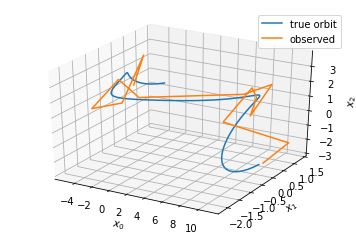


iter: 0
      fun: 37.659039343466901
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([  1.86623145e-04,  -4.41085391e-04,  -1.01098671e-04,
        -1.58765460e-03,  -4.60673674e-06,  -4.34306354e-04,
         2.02862463e-03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 89
      nit: 72
   status: 0
  success: True
        x: array([ 9.4777482 ,  0.90051954, -2.40450343, -1.58959968,  1.01313645,
        7.70949079,  1.03564384])
Smaller cost found.


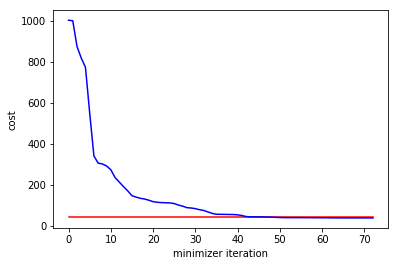

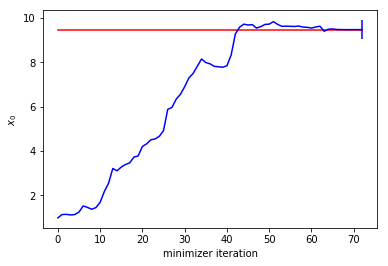

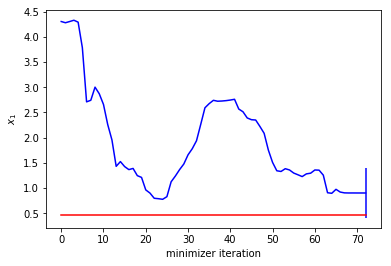

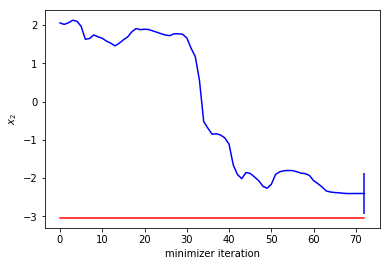

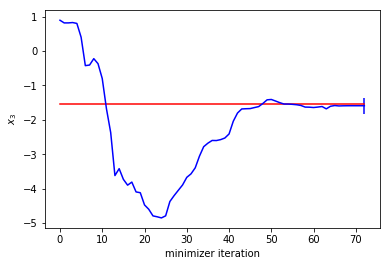

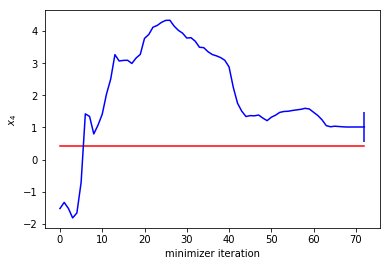

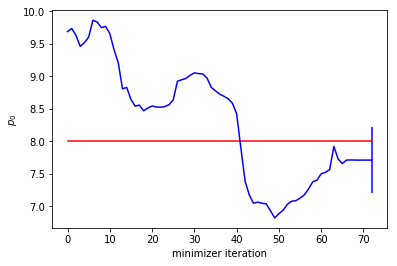

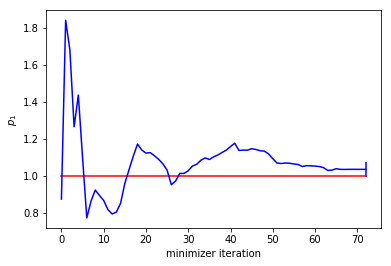

estiamted initial state:	 [ 9.4777482   0.90051954 -2.40450343 -1.58959968  1.01313645]
true initial state:	 [ 9.45532914  0.45773624 -3.04296336 -1.54799715  0.42635464]
1 sigma confidence interval:	 [ 0.42337718  0.49467122  0.54047603  0.22594231  0.4797089 ]

estimated parameters:	 [ 7.70949079  1.03564384]
true parameters:	 [ 8.  1.]
1 sigma confidence interval:	 [ 0.51243908  0.04170083]

initial state and parameter covariance:
 [[  1.79248240e-01   2.43307908e-02  -9.88989326e-03   5.34397340e-02
   -3.70902113e-02  -1.19691471e-01  -2.90127757e-03]
 [  2.43307908e-02   2.44699612e-01   8.46018075e-02  -4.19960221e-02
    1.37913847e-01  -4.74709142e-02   1.21666672e-02]
 [ -9.88989326e-03   8.46018075e-02   2.92114334e-01  -4.87813908e-02
    1.98841284e-01  -3.94804449e-02  -1.82645222e-06]
 [  5.34397340e-02  -4.19960221e-02  -4.87813908e-02   5.10499254e-02
   -5.98578527e-02  -8.64141624e-02   3.71664344e-04]
 [ -3.70902113e-02   1.37913847e-01   1.98841284e-01  -5.98578527



Cost minimization succeeded.

Cause of the minimizer termination:	 b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
final jacobian:	 [  1.86623145e-04  -4.41085391e-04  -1.01098671e-04  -1.58765460e-03
  -4.60673674e-06  -4.34306354e-04   2.02862463e-03]
optimal cost:	 37.6590393435
true cost:	 39.8351151643


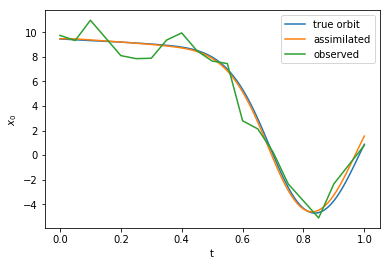

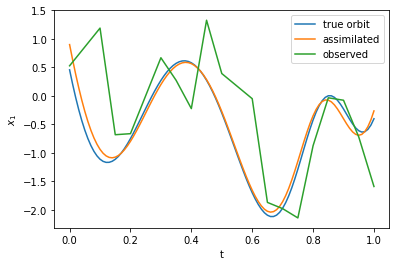

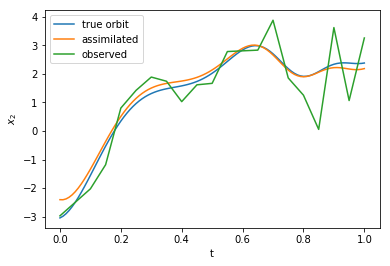

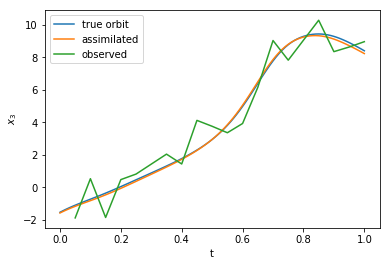

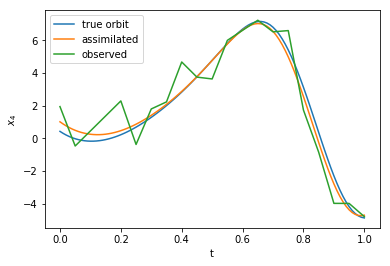

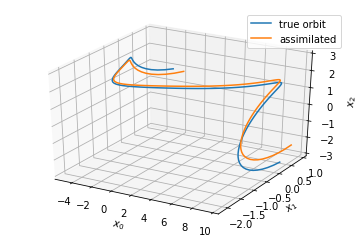

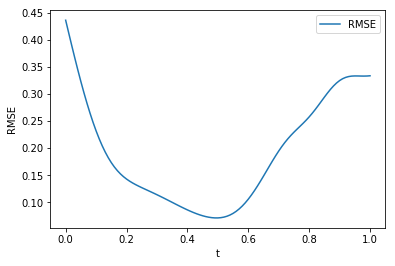

mean RMSE around interval center:  0.078988411647


data:  1


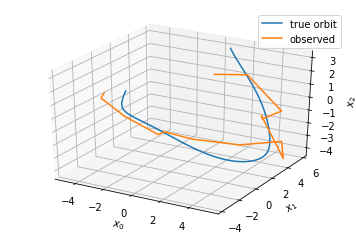


iter: 0
      fun: 44.088455480219238
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.0035956 ,  0.00282443,  0.00100185, -0.00202139,  0.00530331,
        0.00055648,  0.00015058])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 58
      nit: 51
   status: 0
  success: True
        x: array([ 1.43098772,  4.78592118,  2.83295792, -3.17975449, -0.29395921,
        8.08144432,  0.95417444])
Smaller cost found.


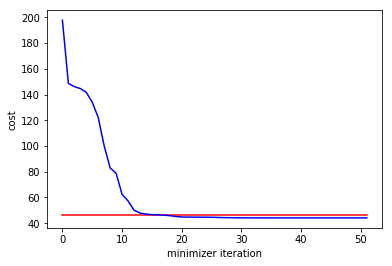

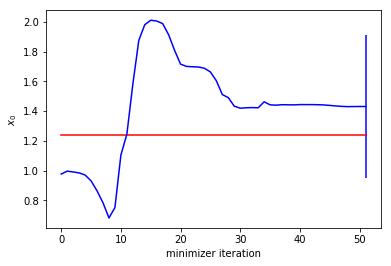

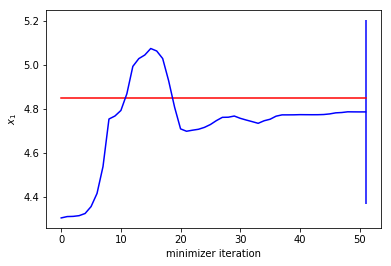

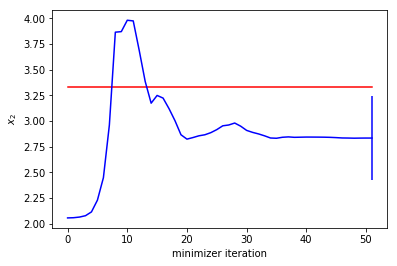

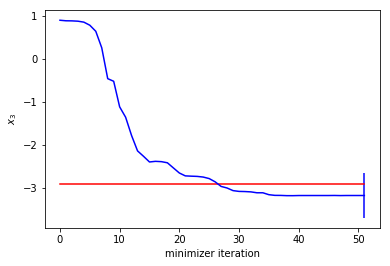

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
from scipy.optimize import minimize
import math

import sys

np.seterr(all='warn', over='raise')        

class Adjoint:
    def __init__(self, model, dt, t, obs_variance, obs, rng):
        self.model = model                                      # Model used for assimilation.
        self.__N = self.model.N
        self.__M = self.model.M
        self.dt = dt
        self.t = t                                              # e.g. t = [0, 0.01, 0.02, ...] when dt = 0.01
        self.steps = len(t)
        self.obs_variance = obs_variance                        # Observation variance
        self.obs = obs                                          # dim(obs)  = steps x N  , obs[i,j] == np.nan means loss of jth variable observation at t[i]. (Especially no observation made at time t[i] if all(obs[i,:] == np.nan) == True.)
        self.x = np.zeros((self.steps, self.__N))               # State variables.
        self.p = np.zeros(self.__M)                             # Parameters.
        self.dx = np.zeros((self.steps, self.__N))              # Frechet derivative of x.
        self.dp = np.zeros(self.__M)                            # Frechet derivative of p.
        self.la = np.zeros((self.steps, self.__N + self.__M))   # Lagrange multipliers.
        self.dla = np.zeros((self.steps, self.__N + self.__M))  # Frechet derivative of la.
        self.cov = np.zeros((self.__N + self.__M, self.__N + self.__M))  # Initial state and parameter covariance calculated by 2nd order adjoint method.
        self.sigma = np.zeros(self.__N + self.__M)                       # 1 sigma confidence interval for initial state and parameter covariance
        self.__cost_trace = []
        self.__x0_p_trace = []
        self.__rng = rng

    def __next_x(self, t, x, p):
        """
        Return next state.
        """
        return x + self.model.calc_dxdt(t, x, p) * self.dt
    
    def __next_dx(self, t, x, p, dx, dp):
        """
        Return next neighboring state.
        """
        return dx + self.model.calc_jacobian(t, x, p) @ np.concatenate((dx, dp)) * self.dt
    
    def __prev_la(self, t, x, p, la):
        """
        Return previous lagrange multiplier w/o observation term.
        """
        return la + self.model.calc_jacobian(t, x, p).transpose() @ la[:self.__N] * self.dt
    
    def __prev_dla(self, t, x, p, dx, dp, la, dla):
        """
        Return previous neighboring lagrange multiplier w/o observation term.
        """
        return self.__prev_la(t, x, p, dla) + (self.model.calc_hessian(t, x, p) @ np.concatenate((dx, dp))).transpose() @ la[:self.__N] * self.dt
        
    def orbit(self):
        """
        Return state orbit.
        """
        for i in range(self.steps-1):
            self.x[i+1] = self.__next_x(self.t[i], self.x[i], self.p)
        return self.x
    
    def neighboring(self):
        """
        Return neighboring state orbit.
        """
        for i in range(self.steps-1):
            self.dx[i+1] = self.__next_dx(self.t[i], self.x[i], self.p, self.dx[i], self.dp)
        return self.dx
    
    def gradient(self, x0_p):
        """
        Return gradient wrt initial state and parameters x0_p = (x[0], pa).
        """
        self.x[0] = x0_p[:self.__N]
        self.p    = x0_p[self.__N:]
        self.orbit()
        for j in range(self.__N):
            if not np.isnan(self.obs[self.steps-1, j]):
                self.la[self.steps-1, j] = (self.x[self.steps-1, j] - self.obs[self.steps-1, j]) / self.obs_variance
            else:
                self.la[self.steps-1, j] = 0.
        for i in range(self.steps-2, -1, -1):
            self.la[i] = self.__prev_la(self.t[i], self.x[i], self.p, self.la[i+1]) # x should be current one.
            for j in range(self.__N):
                if not np.isnan(self.obs[i, j]):
                    self.la[i, j] += (self.x[i, j] - self.obs[i, j]) / self.obs_variance
        return self.la[0]

    def hessian_vector_product(self, dx0_dp):
        """
        Return hessian vector product wrt initial state and parameters dx0_dp = (dx[0], dp).
        """
        self.dx[0] = dx0_dp[:self.__N]
        self.dp    = dx0_dp[self.__N:]
        self.neighboring()
        for j in range(self.__N):
            if not np.isnan(self.obs[self.steps-1, j]):
                self.dla[self.steps-1, j] = self.dx[self.steps-1, j] / self.obs_variance
            else:
                self.dla[self.steps-1, j] = 0.
        for i in range(self.steps-2, -1, -1):
            self.dla[i] = self.__prev_dla(self.t[i], self.x[i], self.p, self.dx[i], self.dp, self.la[i+1], self.dla[i+1])  # x and xi should be current one.
            for j in range(self.__N):
                if not np.isnan(self.obs[i, j]):
                    self.dla[i, j] += self.dx[i, j] / self.obs_variance
        return self.dla[0]
    
    def cost(self, x0_p):
        """
        Return cost function wrt initial state and parameters x0_p = (x[0], p).
        """
        self.x[0] = np.copy(x0_p[:self.__N])
        self.p    = np.copy(x0_p[self.__N:])
        self.orbit()
        __cost=0
        for i in range(self.steps):
            __cost_t=0
            for j in range(self.__N):
                if not np.isnan(self.obs[i, j]):
                    __cost_t += (self.x[i, j] - self.obs[i, j]) ** 2
            __cost += __cost_t
        return __cost/self.obs_variance/2.0
        
    def numerical_gradient(self, x0_p, h):
        """
        Return numerically calculated gradient
        wrt initial state and parameters x0_p = (x[0], p).
        """
        __gr = np.zeros(self.__N + self.__M)
        __c1 = self.cost(x0_p)
        for j in range(self.__N + self.__M):
            __xx = np.copy(x0_p)
            __xx[j] += h
            __c = self.cost(__xx)
            __gr[j] = (__c - __c1)/h
        return __gr
    
    def numerical_covariance(self, x0_p, h):
        """
        Return numerically calculated hessian vector product
        wrt initial state and parameters dx0_dp = (dx[0], dp)
        using analytically calculated gradient.
        """
        __hess = np.zeros((self.__N + self.__M, self.__N + self.__M))
        __gr1 = np.copy(self.gradient(x0_p))
        for i in range(self.__N + self.__M):
            for j in range(self.__N + self.__M):
                __xx = np.copy(x0_p)
                __xx[j] += h
                __gr2 = np.copy(self.gradient(__xx))
                __hess[j,i] = (__gr2[i] - __gr1[i])/h
        return np.linalg.inv(__hess)
    
    def numerical_covariance2(self, x0_p, h):
        """
        Return numerically calculated hessian vector product
        wrt initial state and parameters dx0_dp = (dx[0], dp)
        using numerically calculated gradient.
        """
        __hess = np.zeros((self.__N + self.__M, self.__N + self.__M))
        __gr1 = np.copy(self.numerical_gradient(x0_p, h))
        for i in range(self.__N + self.__M):
            for j in range(self.__N + self.__M):
                __xx = np.copy(x0_p)
                __xx[j] += h
                __gr2 = np.copy(self.numerical_gradient(__xx, h))
                __hess[j,i] = (__gr2[i] - __gr1[i])/h
        return np.linalg.inv(__hess)

    def cbf(self, x0_p):
        """
        Minimizer callback function to store iteration trace.
        """
        self.__cost_trace.append(self.cost(x0_p))
        self.__x0_p_trace.append(list(x0_p))
            
    def minimize(self, x0_p, bounds=None):
        """
        Minimize cost function wrt x0_p = (x[0], p) using L-BFGS-B.
        Give bounds for x0_p such as ((None, None), (-3, None), (None, 2), (-5, 10)).
        (Default no bounds.)
        """
        self.cbf(x0_p)
        return minimize(self.cost, x0_p, jac=self.gradient, method='L-BFGS-B', bounds=bounds, callback=self.cbf, options={'disp': None, 'maxls': 40, 'iprint': -1, 'gtol': 1e-05, 'eps': 1e-08, 'maxiter': 15000, 'ftol': 2.220446049250313e-09, 'maxcor': 10, 'maxfun': 15000})

    def calc_covariance(self):
        """
        Return covariance of initial state and parameters.
        Sqrt of each diagonal element represents 1 sigma confidence interval.
        """
        __hess = np.zeros((self.__N + self.__M, self.__N + self.__M))
        __dx0_dp = np.zeros(self.__N + self.__M)
        for i in range(self.__N + self.__M):
            __dx0_dp.fill(0.)
            __dx0_dp[i] = 1.
            __hess[i] = np.copy(self.hessian_vector_product(__dx0_dp))
        self.cov = np.linalg.inv(__hess)
        __var = np.diag(self.cov)
        self.sigma = np.array([math.sqrt(__var[i]) for i in range(self.__N + self.__M)])
        return self.cov

    def plot_trace(self):
        """
        Plot trace of each initial state and final confidence interval (1 sigma).
        """
        self.__x0_p_trace = np.array(self.__x0_p_trace)
        __minimizer_it = len(self.__x0_p_trace)
        fig = plt.figure()
        plt.plot(self.__cost_trace, 'b')
        plt.xlabel('minimizer iteration')
        plt.ylabel('cost')
        plt.show()
        for j in range(self.__N):
            fig = plt.figure()
            plt.plot(self.__x0_p_trace[:,j], 'b')
            plt.errorbar(__minimizer_it-1, self.__x0_p_trace[-1,j], yerr=self.sigma[j], fmt='b')
            plt.legend()
            plt.xlabel('minimizer iteration')
            plt.ylabel('$x_{' + str(j) + '}$')
            plt.show()
        for j in range(self.__N, self.__N + self.__M):
            fig = plt.figure()
            plt.plot(self.__x0_p_trace[:,j], 'b')
            plt.errorbar(__minimizer_it-1, self.__x0_p_trace[-1,j], yerr=self.sigma[j], fmt='b')
            plt.legend()
            plt.xlabel('minimizer iteration')
            plt.ylabel('$p_{' + str(j-self.__N) + '}$')
            plt.show()

    def plot_trace_twin(self, true_cost, true_x0, true_p):
        """
        Plot trace of each initial state and final confidence interval (1 sigma).
        """
        self.__x0_p_trace = np.array(self.__x0_p_trace)
        __minimizer_it = len(self.__x0_p_trace)
        fig = plt.figure()
        plt.plot([true_cost for _ in range(__minimizer_it)], 'r')
        plt.plot(self.__cost_trace, 'b')
        plt.xlabel('minimizer iteration')
        plt.ylabel('cost')
        plt.show()
        for j in range(self.__N):
            fig = plt.figure()
            plt.plot([true_x0[j] for _ in range(__minimizer_it)], 'r')
            plt.plot(self.__x0_p_trace[:,j], 'b')
            plt.errorbar(__minimizer_it-1, self.__x0_p_trace[-1,j], yerr=self.sigma[j], fmt='b')
            plt.legend()
            plt.xlabel('minimizer iteration')
            plt.ylabel('$x_{' + str(j) + '}$')
            plt.show()
        for j in range(self.__N, self.__N + self.__M):
            fig = plt.figure()
            plt.plot([true_p[j-self.__N] for _ in range(__minimizer_it)], 'r')
            plt.plot(self.__x0_p_trace[:,j], 'b')
            plt.errorbar(__minimizer_it-1, self.__x0_p_trace[-1,j], yerr=self.sigma[j], fmt='b')
            plt.legend()
            plt.xlabel('minimizer iteration')
            plt.ylabel('$p_{' + str(j-self.__N) + '}$')
            plt.show()
    
    def assimilate(self, trials=10, bounds=None, initial_guess_bounds=None):
        """
        Assimilate and calculate confidence intervals.
        Return the minimum cost result in the designated number of trials.
        """
        __mincost = np.inf
        __minres = None
        __min_cost_trace = None
        __min_x0_p_trace = None
        for i in range(trials):
            sys.stderr.write("\niter: %d\n" % i)
#            __x0_p = self.__rng.randn(self.__N + self.__M)
            if initial_guess_bounds==None:
                __x0_p = self.__rng.uniform(low=-10., high=10., size=self.__N+self.__M)
            else:
                __x0_p = np.array([self.__rng.uniform(low=initial_guess_bounds[__j][0], high = initial_guess_bounds[__j][1]) for __j in range(self.__N + self.__M)])
            self.__cost_trace = []
            self.__x0_p_trace = []
            try:
                __res = self.minimize(__x0_p, bounds)
                print(__res, file=sys.stderr)
            except FloatingPointError as e:
                sys.stderr.write('Exception occurred in minimizer: %s\n' % e)
                continue
            if __res.fun < __mincost:
                sys.stderr.write("Smaller cost found.\n")
                __mincost = __res.fun
                __minres = __res
                __min_cost_trace = np.copy(self.__cost_trace)
                __min_x0_p_trace = np.copy(self.__x0_p_trace)
        if __minres == None:
            sys.stderr.write("\nAssimilation failed in all the %d trials.\n" % trials)
            return None
        
        self.gradient(__minres.x)
        self.calc_covariance()
        self.__cost_trace = __min_cost_trace
        self.__x0_p_trace = __min_x0_p_trace
        self.plot_trace()
        return __minres
    
    def twin_experiment(self, true_cost, true_x0, true_p, trials=10, bounds=None, initial_guess_bounds=None):
        """
        Assimilate and calculate confidence intervals.
        Return the minimum cost result in the designated number of trials.
        Estimated result is shown compared to the true initial state and parameters.
        """
        __mincost = np.inf
        __minres = None
        __min_cost_trace = None
        __min_x0_p_trace = None
        for i in range(trials):
            sys.stderr.write("\niter: %d\n" % i)
#            __x0_p = self.__rng.randn(self.__N + self.__M)
            if initial_guess_bounds==None:
                __x0_p = self.__rng.uniform(low=-10., high=10., size=self.__N+self.__M)
            else:
                __x0_p = np.array([self.__rng.uniform(low=initial_guess_bounds[__j][0], high = initial_guess_bounds[__j][1]) for __j in range(self.__N + self.__M)])
            self.__cost_trace = []
            self.__x0_p_trace = []
            try:
                __res = self.minimize(__x0_p, bounds)
                print(__res, file=sys.stderr)
            except FloatingPointError as e:
                sys.stderr.write('Exception occurred in minimizer: %s\n' % e)
                continue
            if __res.fun < __mincost:
                sys.stderr.write("Smaller cost found.\n")
                __mincost = __res.fun
                __minres = __res
                __min_cost_trace = np.copy(self.__cost_trace)
                __min_x0_p_trace = np.copy(self.__x0_p_trace)
        if __minres == None:
            sys.stderr.write("\nAssimilation failed in all the %d trials.\n" % trials)
            return None
        
        self.gradient(__minres.x)
        self.calc_covariance()
        self.__cost_trace = __min_cost_trace
        self.__x0_p_trace = __min_x0_p_trace
        self.plot_trace_twin(true_cost, true_x0, true_p)
        return __minres


#%%
def handler(func, *args):
    return func(*args)

#%%
def plot_orbit3d(dat, label):
    """
    Plot first three state dimensions.
    """
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(dat[:,0],dat[:,1],dat[:,2], label=label)
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$x_2$')
    plt.show()

def plot_orbit2_3d(dat1, dat2, label1, label2):
    """
    Plot first three state dimensions for two data.
    """
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(dat1[:,0],dat1[:,1],dat1[:,2],label=label1)
    ax.plot(dat2[:,0],dat2[:,1],dat2[:,2],label=label2)
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$x_2$')
    plt.legend()
    plt.show()

def plot_orbit3_3d(dat1, dat2, dat3, label1, label2, label3):
    """
    Plot first three state dimensions for three data.
    """
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(dat1[:,0],dat1[:,1],dat1[:,2],label=label1)
    ax.plot(dat2[:,0],dat2[:,1],dat2[:,2],label=label2)
    ax.plot(dat3[:,0],dat3[:,1],dat3[:,2],label=label3)
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$x_2$')
    plt.legend()
    plt.show()

def plot_orbit2_1d(t, assim, obs):
    """
    Plot each state dimension for true state, assimilated state, and observation state.
    """
    for j in range(len(assim[0])):
        mask = np.array(list(map(np.isnan, obs[:,j])))
        fig = plt.figure()
        plt.plot(t, assim[:,j], label='assimilated')
        plt.plot(t[~mask], obs[:,j][~mask], label='observed')
        plt.xlabel('t')
        plt.ylabel('$x_{' + str(j) + '}$')
        plt.legend()
        plt.show()

def plot_orbit3_1d(t, tob, assim, obs):
    """
    Plot each state dimension for true state, assimilated state, and observation state.
    """
    for j in range(len(tob[0])):
        mask = np.array(list(map(np.isnan, obs[:,j])))
        fig = plt.figure()
        plt.plot(t, tob[:,j], label='true orbit')
        plt.plot(t, assim[:,j], label='assimilated')
        plt.plot(t[~mask], obs[:,j][~mask], label='observed')
        plt.xlabel('t')
        plt.ylabel('$x_{' + str(j) + '}$')
        plt.legend()
        plt.show()
        
def plot_RMSE(t, tob, assim):
    """
    Plot RMSE of states.
    """
    fig = plt.figure()
    plt.plot(t, [np.linalg.norm(assim[i] - tob[i])/math.sqrt(len(tob[0])) for i in range(len(t))], label='RMSE')
    plt.xlabel('t')
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()

def calc_RMSE(t, tob, assim):
    N = len(tob[0])
    return np.mean([np.linalg.norm(assim[i] - tob[i])/math.sqrt(N) for i in range(int(len(t)*0.4),int(len(t)*0.6))])


import pathlib

def twin_experiment_given_data(model, true_params, tob, obs, obs_variance, dt, trials=10, bounds=None, initial_guess_bounds=None):
    """
    Conduct twin experiment given true parameters (true_params), true orbit (tob), and observation (obs)
    """
    __N = model.N
    __steps = len(tob)
    __t = np.array([dt*i for i in range(__steps)])
    
    if __N >= 3:
        __obs_mask = np.array(list(map(np.isnan, obs)))
        __obs_mask_row = [all(~__obs_mask[i,:3]) for i in range(__steps)]
        plot_orbit2_3d(tob, obs[__obs_mask_row], "true orbit", "observed")
    
    __rng = np.random.RandomState(0)
    __scheme = Adjoint(model, dt, __t, obs_variance, obs, __rng)
    __true_cost = __scheme.cost(np.concatenate((tob[0], true_params)))
    
    __minres = __scheme.twin_experiment(__true_cost, tob[0], true_params, trials, bounds, initial_guess_bounds)
    if (__minres == None):
        return
    
    if __minres.success:
        print('\n\nCost minimization succeeded.\n', file=sys.stderr)
    else:
        print('\n\nCost minimization failed.\n', file=sys.stderr)
    print('Cause of the minimizer termination:\t', __minres.message, file=sys.stderr)
    print('final jacobian:\t', __minres.jac, file=sys.stderr)
    print('optimal cost:\t', __minres.fun, file=sys.stderr)
    print('true cost:\t', __true_cost, file=sys.stderr)
    
    print('estiamted initial state:\t', __minres.x[:__N])
    print('true initial state:\t', tob[0])
    print('1 sigma confidence interval:\t', __scheme.sigma[:__N])
    print('\nestimated parameters:\t', __minres.x[__N:])
    print('true parameters:\t', true_params)
    print('1 sigma confidence interval:\t', __scheme.sigma[__N:])
    print("\ninitial state and parameter covariance:\n", __scheme.cov)
    
    plot_orbit3_1d(__t, tob, __scheme.x, obs)
    plot_orbit2_3d(tob, __scheme.x, 'true orbit', 'assimilated')
    plot_RMSE(__t, tob, __scheme.x)
    print ("mean RMSE around interval center: ", calc_RMSE(__t, tob, __scheme.x), file=sys.stderr)


def twin_experiment_given_data_file(model, true_params, true_orbit_file, observed_file, obs_variance, dt, T, trials=10, bounds=None, initial_guess_bounds=None, missing_values={'NA', 'nan'}):
    """
    Conduct twin experiment given true parameters (true_params), true_orbit_file, and observation_file
    """
    __steps = int(T/dt) + 1
    __tob = np.genfromtxt(true_orbit_file, max_rows=__steps)
    __obs = np.genfromtxt(observed_file, missing_values=missing_values, max_rows=__steps)
    twin_experiment_given_data(model, true_params, __tob, __obs, obs_variance, dt, trials, bounds, initial_guess_bounds)


def twin_experiment_with_data_generation(model, true_params, obs_variance, obs_iteration, dt, spinup, T, x0_generating_func, generation_seed, trials=10, bounds=None, initial_guess_bounds=None):
    """
    Conduct twin experiment given true parameters (true_params) with generating observation data.
    spinup is the duration required for model spin-up.
    T is the data generating duration.
    x0_generating_func(N, true_params, rng) is a function to generate x[0] preceding spin-up.
    """
    __N = model.N
    __spinup_steps = int(spinup/dt)
    __total_T = spinup + T
    __t = np.concatenate((np.arange(0., __total_T, dt), np.array([__total_T])))
    __steps = len(__t)
    
    __rng = np.random.RandomState(generation_seed)
    __scheme = Adjoint(model, dt, __t, obs_variance, np.zeros((__steps, __N)), __rng)
    __scheme.p = true_params    
    __scheme.x[0] = x0_generating_func(__N, true_params, __rng)
    __true_orbit = __scheme.orbit()[__spinup_steps:]
    __observed = __true_orbit + math.sqrt(obs_variance) * __rng.randn(__steps-__spinup_steps, __N)

    # simulate sparse observation and missing values
    for __i in range(0, __steps-__spinup_steps-1, obs_iteration):
        __mask = __rng.randint(__N, size=__N)
        for __j in range(__N):
            if __mask[__j] == 0:
                __observed[__i, __j] = np.nan
        for __k in range(1, obs_iteration):
            __observed[__i+__k] = np.nan

    __path = "../data/" + model.__class__.__name__ + "/N_"\
           + str(__N) + "/p_"  + "_".join(list(map(str, true_params)))\
           + "/obsvar_" + str(obs_variance) +  "/obsiter_" + str(obs_iteration) + "/dt_" + str(dt)\
           + "/spinup_" + str(spinup) + "/T_" + str(T) + "/seed_" + str(generation_seed) + "/"
    pathlib.Path(__path).mkdir(parents=True, exist_ok=True)
    np.savetxt(__path + "true.tsv", __true_orbit, delimiter='\t')
    np.savetxt(__path + "observed.tsv", __observed, delimiter='\t')
    
    twin_experiment_given_data(model, true_params, __true_orbit, __observed, obs_variance, dt, trials, bounds, initial_guess_bounds)


def twin_experiment_with_data_generation_differentx0_iteration(model, true_params, obs_variance, obs_iteration, dt, spinup, T, x0_generating_func, generation_trials=10, trials=10, bounds=None, initial_guess_bounds=None):
    """
    Conduct twin experiment given true parameters (true_params) with generating observation data 'generation_trials' times.
    Observation data is generated for different initial x[0] every time.
    See twin_experiment_with_data_generation for the details.
    """
    for __i in range(generation_trials):
        print("data: ", __i)
        twin_experiment_with_data_generation(model, true_params, obs_variance, obs_iteration, dt, spinup, T, x0_generating_func, __i, trials, bounds, initial_guess_bounds)


def __twin_experiment_given_data_accum_minres(model, true_params, tob, obs, obs_variance, dt, x0_p_acc, cov_acc, trials=10, bounds=None, initial_guess_bounds=None):
    __N = model.N
    __M = model.M
    __steps = len(tob)
    __t = np.array([dt*i for i in range(__steps)])
    
    if __N >= 3:
        __obs_mask = np.array(list(map(np.isnan, obs)))
        __obs_mask_row = [all(~__obs_mask[i,:3]) for i in range(__steps)]
        plot_orbit2_3d(tob, obs[__obs_mask_row], "true orbit", "observed")
    
    __rng = np.random.RandomState(0)
    __scheme = Adjoint(model, dt, __t, obs_variance, obs, __rng)
    __true_cost = __scheme.cost(np.concatenate((tob[0], true_params)))
    
    __minres = __scheme.twin_experiment(__true_cost, tob[0], true_params, trials, bounds, initial_guess_bounds)

    if __minres != None and __minres.success:
        x0_p_acc = np.concatenate((x0_p_acc, __minres.x.reshape(1, __N + __M)))
        cov_acc  = np.concatenate((cov_acc , np.reshape(__scheme.cov, (1, __N + __M, __N + __M))))
    return x0_p_acc, cov_acc    

def twin_experiment_with_data_generation_samex0_iteration(model, x0, true_params, obs_variance, obs_iteration, dt, spinup, T, generation_trials=10, trials=10, bounds=None, initial_guess_bounds=None):
    """
    Conduct twin experiment given true parameters (true_params) with generating observation data.
    spinup is the duration required for model spin-up.
    T is the data generating duration.
    x0_generating_func(N, true_params, rng) is a function to generate x[0] preceding spin-up.
    Observation data is generated 'generation_trials' times.
    x[0] is the same through every observation data.
    Experimental sample covariance and mean second order adjoint covariance is reported.
    """
    __N = model.N
    __M = model.M
    __spinup_steps = int(spinup/dt)
    __total_T = spinup + T
    __t = np.concatenate((np.arange(0., __total_T, dt), np.array([__total_T])))
    __steps = len(__t)
    
    __rng_onetime = np.random.RandomState(0)
    __scheme = Adjoint(model, dt, __t, obs_variance, np.zeros((__steps, __N)), __rng_onetime)
    __scheme.p = true_params    
    __scheme.x[0] = x0
    __true_orbit = __scheme.orbit()[__spinup_steps:]
    __maskall = __rng_onetime.randint(__N, size=(__steps, __N))

    __x0_p_acc = np.empty((0, __N + __M))
    __cov_acc  = np.empty((0, __N + __M, __N + __M))
    
    for __obs_variation_seed in range(generation_trials):
        print("obs_variation_seed:", __obs_variation_seed)
        __rng = np.random.RandomState(__obs_variation_seed)
        __observed = __true_orbit + math.sqrt(obs_variance) * __rng.randn(__steps-__spinup_steps, __N)

        # simulate sparse observation and missing values
        for __i in range(0, __steps-__spinup_steps-1, obs_iteration):
            for __j in range(__N):
                if __maskall[__i, __j] == 0:
                    __observed[__i, __j] = np.nan
            for __k in range(1, obs_iteration):
                __observed[__i+__k] = np.nan
    
        __path = "../data/" + model.__class__.__name__ + "/N_"\
               + str(__N) + "/p_"  + "_".join(list(map(str, true_params)))\
               + "/obsvar_" + str(obs_variance) +  "/obsiter_" + str(obs_iteration) + "/dt_" + str(dt)\
               + "/spinup_" + str(spinup) + "/T_" + str(T) + "/seed_0/obsvarseed_" + str(__obs_variation_seed) + "/"
        pathlib.Path(__path).mkdir(parents=True, exist_ok=True)
        np.savetxt(__path + "true.tsv", __true_orbit, delimiter='\t')
        np.savetxt(__path + "observed.tsv", __observed, delimiter='\t')
        
        __x0_p_acc, __cov_acc = __twin_experiment_given_data_accum_minres(model, true_params, __true_orbit, __observed, obs_variance, dt, __x0_p_acc, __cov_acc, trials, bounds, initial_guess_bounds)
        
    __cov_exp = np.cov(__x0_p_acc.transpose())
    print("experimental sample (x0, p) covariance:\n", __cov_exp)
    __cov_mean = np.mean(__cov_acc, axis=0)
    print("\nmean second order adjoint (x0, p) covariance:\n", __cov_mean)
    print("absolute error:", __cov_mean - __cov_exp)
    print("relative error:", (__cov_mean - __cov_exp)/__cov_exp)
    

#%%
def assimilate(model, observed_file, obs_variance, dt, trials=10, bounds=None, initial_guess_bounds=None, missing_values={'NA', 'nan'}):
    """
    Conduct data assimilation given observation_file (row: each time (every dt) observed x[t]).
    Missing data appear as string in missing_values in the observed_file.
    """
    __N = model.N
    __obs = np.genfromtxt(observed_file, missing_values=missing_values)
    __steps = len(__obs)
    __t = np.array([dt*i for i in range(__steps)])
        
    __rng = np.random.RandomState(0)

    __scheme = discrete4DVar.Adjoint(model, dt, __t, obs_variance, __obs, __rng)
    
    __minres = __scheme.assimilate(trials, bounds, initial_guess_bounds)
    if (__minres == None):
        return
    
    if __minres.success:
        print('\n\nCost minimization succeeded.\n', file=sys.stderr)
    else:
        print('\n\nCost minimization failed.\n', file=sys.stderr)
    print('Cause of the minimizer termination:\t', __minres.message, file=sys.stderr)
    print('final jacobian:\t', __minres.jac, file=sys.stderr)
    print('optimal cost:\t', __minres.fun, file=sys.stderr)
    
    print('estiamted initial state:', __minres.x[:__N])
    print('1 sigma confidence interval:\t', __scheme.sigma[:__N])
    print('\nestimated parameters:\t', __minres.x[__N:])
    print('1 sigma confidence interval:\t', __scheme.sigma[__N:])
    print("\ninitial state and parameter covariance:\n", __scheme.cov)
    
    plot_orbit2_1d(__t, __scheme.x, __obs)
    if __N >= 3:
        __obs_mask = np.array(list(map(np.isnan, __obs)))
        __obs_mask_row = [all(~__obs_mask[i,:3]) for i in range(__steps)]
        plot_orbit2_3d(__scheme.x, __obs[__obs_mask_row], 'assimilated', 'observed')


#%%
class Model:          # Fill in your model here.
    def __init__(self, N, M):
        self.N = N    # Dimension of state.      dim(x)
        self.M = M    # Dimension of parameters. dim(p)
        self.dxdt = np.zeros(self.N)  # dxdt of continuous model
        self.jacobian = np.zeros((self.N, self.N + self.M))  # Jacobian of continuous model
        self.hessian = np.zeros((self.N, self.N + self.M, self.N + self.M))  # Hessian of continuous model
    
    def calc_dxdt(self, t, x, p):
        """
        Return dxdt.
        Next state is calculated as follows,
        x(t+1) = x(t) + dt * dxdt(t, x(t), p)
        """
        # Fill in dxdt here.
        
        return self.dxdt
    
    def calc_jacobian(self, t, x, p):
        """
        Return Jacobian.
        Tangent linear model is calculated as follows,
        dx(t+1) = (I + dt * jacobian(t ,x(t), p)) @ dx(t).
        """        
        # Fill in Jacobian here.

        return self.jacobian

    def calc_hessian(self, t, x, p):
        """
        Return Hessian.
        """
        # Fill in Hessian here.

        return self.hessian

#%%
class Lorenz96:       # Example code for Lorenz96 model with two parameters
    def __init__(self, N, M):
        self.N = N    # Dimension of state.      dim(x)
        self.M = M    # Dimension of parameters. dim(p)
        self.dxdt = np.zeros(self.N)  # dxdt of continuous model
        self.jacobian = np.zeros((self.N, self.N + self.M))  # Jacobian of continuous model
        self.hessian = np.zeros((self.N, self.N + self.M, self.N + self.M))  # Hessian of continuous model
    
    def calc_dxdt(self, t, x, p):
        """
        Return dxdt.
        Next state is calculated as follows,
        x(t+1) = x(t) + dt * dxdt(t, x(t), p)
        """
        # Fill in dxdt here.
        self.dxdt[0]        = p[1] * (x[1]   - x[self.N-2]) * x[self.N-1] + p[0] - x[0]
        self.dxdt[1]        = p[1] * (x[2]   - x[self.N-1]) * x[0]        + p[0] - x[1]
        for i in range(2, self.N-1):
            self.dxdt[i]    = p[1] * (x[i+1] - x[i-2])      * x[i-1]      + p[0] - x[i]
        self.dxdt[self.N-1] = p[1] * (x[0]   - x[self.N-3]) * x[self.N-2] + p[0] - x[self.N-1]
        
        return self.dxdt
    
    def calc_jacobian(self, t, x, p):
        """
        Return Jacobian.
        Tangent linear model is calculated as follows,
        dx(t+1) = (I + dt * jacobian(t ,x(t), p)) @ dx(t).
        """        
        # Fill in Jacobian here.
        for i in range(self.N):
            for j in range(self.N + self.M):
                self.jacobian[i,j] = p[1] * ((((i+1) % self.N) == j) - (((i-2) % self.N) == j)) * x[(i-1) % self.N]\
                                   + p[1] * (x[(i+1) % self.N]       - x[(i-2) % self.N])       * (((i-1) % self.N) == j)\
                                   + (self.N+1 == j)    * (x[(i+1) % self.N]       - x[(i-2) % self.N])       * x[(i-1) % self.N]\
                                   + (self.N   == j)\
                                   - (i        == j)
        return self.jacobian

    def calc_hessian(self, t, x, p):
        """
        Return Hessian.
        """
        # Fill in Hessian here.
        for i in range(self.N):
            for j in range(self.N + self.M):
                for k in range(self.N + self.M):
                    self.hessian[i,j,k] = ((self.N+1)==j) * ((((i+1)%self.N)==k) - (((i-2)%self.N)==k)) * x[(i-1)%self.N]\
                                        + ((self.N+1)==j) * (x[(i+1)%self.N]     - x[(i-2)%self.N])     * (((i-1)%self.N)==k)\
                                        + ((self.N+1)==k) * ((((i+1)%self.N)==j) - (((i-2)%self.N)==j)) * x[(i-1)%self.N]\
                                        + p[1]            * ((((i+1)%self.N)==j) - (((i-2)%self.N)==j)) * (((i-1)%self.N)==k)\
                                        + ((self.N+1)==k) * (x[(i+1)%self.N]     - x[(i-2)%self.N])     * (((i-1)%self.N)==j)\
                                        + p[1]            * ((((i+1)%self.N)==k) - (((i-2)%self.N)==k)) * (((i-1)%self.N)==j)
        return self.hessian


def lorenz96_x0_generating_func(N, params, rng):
    x0 = params[0] * np.ones(N)
    x0[rng.randint(N)] += 0.1 * rng.randn()
    return x0
    
def main():
    N = 5
    M = 2
    true_p = np.array([8., 1.])
    obs_variance = 1.
    obs_iteration = 5
    dt = 0.01
    
    year = 1
    day = 365 * year
    spinup = day * 0.2
    
    T = 1.
    generation_trials = 2
    trials = 1
    
    lorenz = Lorenz96(N, M)    

#    bounds = ((None, None), (None, None), (None, None), (None, None), (None, None), (0, None), (None, None))
    bounds=None
    initial_guess_bounds = ((-10, 10), (-10, 10), (-10, 10), (-10, 10), (-10, 10), (0, 15), (0, 2))

    twin_experiment_with_data_generation_differentx0_iteration(lorenz, true_p, obs_variance, obs_iteration, dt, spinup, T, lorenz96_x0_generating_func, generation_trials, trials, bounds, initial_guess_bounds)


main()